# ALPHA FACTORS

In [1]:
import yaml
import os

# Retrieve parameters from configuration file
with open("../conf.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile)

BUNDLE_FOLDER = cfg['quantopian']['dataset1']['bundle_folder']
BUNDLE_NAME = cfg['quantopian']['dataset1']['bundle_name']
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_DATA = cfg['quantopian']['dataset1']['sector_data']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
bundle_path = os.path.join(os.getcwd(), '..', 'data', BUNDLE_FOLDER)
sector_path = os.path.join(os.getcwd(), '..', 'data', SECTOR_FOLDER, SECTOR_DATA)
sector_file = os.path.join(os.getcwd(), '..', 'data', SECTOR_FOLDER, SECTOR_NAMES)
os.path.isdir(bundle_path)

True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quant_helper

In [3]:
from zipline.data import bundles
from zipline.utils.calendars import get_calendar
from zipline.pipeline.factors import AverageDollarVolume, Returns, SimpleMovingAverage
from zipline.pipeline import Pipeline
from zipline.data.data_portal import DataPortal

In [4]:
import alphalens as al

In [5]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Registering CSV Data Bundle
http://www.zipline.io/bundles.html#ingesting-data-from-csv-files

In [6]:
os.environ['ZIPLINE_ROOT'] = bundle_path
ingest_func = bundles.csvdir.csvdir_equities(['daily'], BUNDLE_NAME)
bundles.register(BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


## Build pipeline engine
* Universe Rule: Rule to select assets in analysis
* Universe end date: 2016
* Universe should avoid several issues, like survivor bias
To create a pandas DF, pipeline engine should be run

In [7]:
universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(BUNDLE_NAME)
engine = quant_helper.build_pipeline_engine(bundle_data, trading_calendar)

In [8]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')
universe_start_date = universe_end_date - pd.DateOffset(years=5)
print(universe_start_date, universe_end_date)

2011-01-05 00:00:00+00:00 2016-01-05 00:00:00+00:00


In [9]:
# 2 years of data is used in factors computation
# Note: Going back 2 years falls on a day when the market is closed. 
# Pipeline package doesn't handle start or end dates that don't fall on days when the market is open.
# To fix this, we went back 2 extra days to fall on the next day when the market is open.
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2) 
print(universe_end_date)

2016-01-05 00:00:00+00:00


In [10]:
# Extract the number of assets at universe_end_date
# running the pipeline creates a pandas DF index with universe stocks
universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()

print('Number of tickers: {}'.format(len(universe_tickers)))
print(universe_tickers[:5])

Number of tickers: 490
[Equity(0 [A]), Equity(1 [AAL]), Equity(2 [AAP]), Equity(3 [AAPL]), Equity(4 [ABBV])]


### Attach prices data to the pipeline using a DataPortal
DataPortal deals with calendar, prices alignment and other issues. DataPortal is used by a pricing function in order to obtain a pandas DF

Returned pandas DF indexed by Date and each stock in the universe is a columns

In [11]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

In [12]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [13]:
prices_df = get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_start_date,
        universe_end_date)
returns_df = prices_df.pct_change()[1:].fillna(0)  # convert prices into returns

prices_df.head()

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-06 00:00:00+00:00,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.270,30.936,...,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07 00:00:00+00:00,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.040,30.756,...,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2011-01-10 00:00:00+00:00,57.255,11.044,61.242,43.507,NaN,30.972,19.831,40.972,32.960,30.846,...,19.028,25.149,59.658,33.599,25.832,NaN,30.604,49.978,22.766,NaN
2011-01-11 00:00:00+00:00,57.147,10.562,60.879,43.404,NaN,31.275,19.790,41.534,32.980,31.116,...,19.053,25.405,60.102,33.846,25.990,NaN,30.406,51.761,22.936,NaN
2011-01-12 00:00:00+00:00,58.133,10.475,61.694,43.757,NaN,31.088,19.770,42.488,33.572,31.124,...,19.148,25.803,60.809,34.766,26.104,NaN,30.486,52.524,22.663,NaN


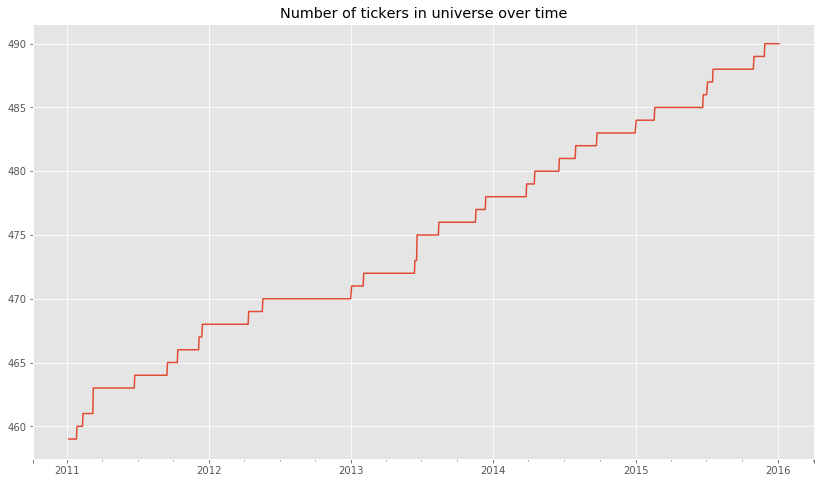

In [14]:
prices_df.notna().sum(axis=1).plot()
plt.title('Number of tickers in universe over time')
plt.show()

In [15]:
print(universe_start_date, universe_end_date)
prices_df.info()

2011-01-05 00:00:00+00:00 2016-01-05 00:00:00+00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2011-01-06 to 2016-01-05
Freq: C
Columns: 490 entries, Equity(0 [A]) to Equity(490 [ZTS])
dtypes: float64(490)
memory usage: 4.7 MB


## Alpha Factor Creation: Add steps to the pipeline

**Create an alpha factor based on momentum: One-year pct return**

$1YearReturn_t = \frac{price_{t} - price_{t-252}}{price_{t-252}}$

Compute the factor in several ways:
* Raw factor: No additional computation added
* Sector de-meaned: Neutralize sector risk (not exposed by overall movements in a sector)
* Ranked: Categorize returns in a ranking, reducing noise (relative changes in a portfolio and outliers) 
https://www.zipline.io/appendix.html#zipline.pipeline.factors.Factor.rank
* z-scored: Standardize factor returns in order to ease comparison , combination and evaluation. In addition, make alpha factors comparable after ranking when number of stocks changes (useful to apply rank and then z-score)
https://www.zipline.io/appendix.html#zipline.pipeline.factors.zscore
* smoothing: Decrease noise and missing by compute a moving average over a time window (simple or exponential)
https://www.zipline.io/appendix.html#zipline.pipeline.factors.SimpleMovingAverage
https://www.zipline.io/appendix.html#zipline.pipeline.factors.ExponentialWeightedMovingAverage

### Sector data helper function
The sectors are represented by integers, as sector is needed in demeaning

Inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [16]:
sector = quant_helper.get_sectors(sector_path)
print(len(sector.data), np.unique(sector.data))

491 [-1  0  1  2  3  4  5  6  7  8  9 10]


In [17]:
## Sector Labels
sector_names = pd.read_csv(sector_file)
sector_names = sector_names[['Sector','sector_id']]
sector_names = sector_names.drop_duplicates()
sector_names = sector_names.append(pd.DataFrame([['no sector assigned',-1]], columns = sector_names.columns))
sector_names

,Sector,sector_id
0,Healthcare,0
1,Technology,1
2,Consumer Defensive,2
3,Industrials,3
4,Utilities,4
5,Financial Services,5
6,Real Estate,6
7,Communication Services,7
8,Consumer Cyclical,8
9,Energy,9


In [18]:
# raw factors
rets_1d_raw = (
    Returns(window_length=2, mask=universe)
)
rets_1y_raw = (
    Returns(window_length=252, mask=universe)
)

# sector demean, rank and z-score
rets_1d = (
    Returns(window_length=2, mask=universe).
    demean(groupby=sector). #we use the custom Sector class that we reviewed earlier
    rank().
    zscore()
)
rets_1y = (
    Returns(window_length=252, mask=universe).
    demean(groupby=sector). #we use the custom Sector class that we reviewed earlier
    rank()
)

# 1-year returns smoothed
rets_1y_smooth = (
    SimpleMovingAverage(inputs=[rets_1y], window_length=5)
)



In [19]:
# create a pipeline called
p = Pipeline(screen=universe)

# add the factors to the pipeline
p.add(rets_1d_raw, 'rets_1d_raw')
p.add(rets_1y_raw, 'Momentum_1YR')
p.add(rets_1y_smooth, 'Smoothed_Momentum_Factor')
p.add(rets_1y_smooth, 'Momentum_1YR_demean_by_sector_ranked_zscore')

In [20]:
# Run the pipeline to obtain a factor returns pandas DF
factors_df = engine.run_pipeline(p, factor_start_date, universe_end_date)
factors_df.head()

Momentum_1YR  \
2014-01-03 00:00:00+00:00 Equity(0 [A])         0.799433   
                          Equity(1 [AAL])       0.856600   
                          Equity(2 [AAP])       0.518050   
                          Equity(3 [AAPL])      0.045903   
                          Equity(4 [ABBV])      0.551403   

                                            Momentum_1YR_demean_by_sector_ranked_zscore  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                           435.4   
                          Equity(1 [AAL])                                         446.2   
                          Equity(2 [AAP])                                         266.0   
                          Equity(3 [AAPL])                                         35.2   
                          Equity(4 [ABBV])                                        359.5   

                                            Smoothed_Momentum_Factor  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                        435.4   
                          Equity(1 [AAL])                      446.2   
                          Equity(2 [AAP])                      266.0   
                          Equity(3 [AAPL])                      35.2   
                          Equity(4 [ABBV])                     359.5   

                                            rets_1d_raw  
2014-01-03 00:00:00+00:00 Equity(0 [A])        0.001321  
                          Equity(1 [AAL])      0.004360  
                          Equity(2 [AAP])     -0.008497  
                          Equity(3 [AAPL])    -0.014053  
                          Equity(4 [ABBV])    -0.015713

### Checking results and manual replication

In [21]:
print(factor_start_date, universe_end_date)
factors_df.info()

2014-01-03 00:00:00+00:00 2016-01-05 00:00:00+00:00
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 244259 entries, (2014-01-03 00:00:00+00:00, Equity(0 [A])) to (2016-01-05 00:00:00+00:00, Equity(490 [ZTS]))
Data columns (total 4 columns):
Momentum_1YR                                   241113 non-null float64
Momentum_1YR_demean_by_sector_ranked_zscore    239517 non-null float64
Smoothed_Momentum_Factor                       239517 non-null float64
rets_1d_raw                                    244247 non-null float64
dtypes: float64(4)
memory usage: 8.4+ MB


### Verify factor computation: 1d returns

In [22]:
ticker = prices_df.columns[0]
dates = list(pd.date_range('2014-01-03', '2014-01-07'))

In [23]:
factors_df.loc[(dates, ticker) , 'rets_1d_raw']

2014-01-03 00:00:00+00:00  Equity(0 [A])    0.001321
2014-01-06 00:00:00+00:00  Equity(0 [A])    0.006951
2014-01-07 00:00:00+00:00  Equity(0 [A])    0.005740
Name: rets_1d_raw, dtype: float64

In [24]:
prices_df[ticker].pct_change(1)['2014-01-01': '2014-01-06']

2014-01-02 00:00:00+00:00    0.001321
2014-01-03 00:00:00+00:00    0.006951
2014-01-06 00:00:00+00:00    0.005740
Freq: C, Name: Equity(0 [A]), dtype: float64

#### Check number of stocks in universe

In [25]:
# get list of stocks in our portfolio (tickers that identify each stock)
assets = factors_df.index.levels[1].values.tolist()
print("stock universe number of stocks {}, and number of stocks for which we have factor values {}".format(len(universe_tickers), len(assets)))

stock universe number of stocks 490, and number of stocks for which we have factor values 490


#### Compare to the factor data for a single stock

In [26]:
stock_index_name = factors_df.index.get_level_values(1)[3] #just pick a stock; in this case, stock number 3 is AAPL
single_stock_factor_df = factors_df[np.in1d(factors_df.index.get_level_values(1), [stock_index_name])]

In [27]:
pd.concat([single_stock_factor_df.head(2), single_stock_factor_df.tail(2)], axis=0)

,,Momentum_1YR,Momentum_1YR_demean_by_sector_ranked_zscore,Smoothed_Momentum_Factor,rets_1d_raw
2014-01-03 00:00:00+00:00,Equity(3 [AAPL]),0.045903,35.2,35.2,-0.014053
2014-01-06 00:00:00+00:00,Equity(3 [AAPL]),0.052237,34.2,34.2,-0.021972
2016-01-04 00:00:00+00:00,Equity(3 [AAPL]),-0.020871,165.2,165.2,-0.019199
2016-01-05 00:00:00+00:00,Equity(3 [AAPL]),0.008378,171.6,171.6,0.000855


In [28]:
single_stock_factor_df.shape

(505, 4)

In [29]:
#graphviz lets us visualize the pipeline
#import graphviz
#p.show_graph(format='png')

## Factor Evaluation: Forward Returns

Factor Evaluation Techniques:
* (Weighted) Factor returns: Return on a theoretical portfolio, performing weight calculation driven by the alpha factor itself. Usefull when date range and universe is the same
* Sharpe ratio
* Information coefficient
* Information ratio
* Quantile Analysis
* Turnover analysis

First of all, forward returns must be computed and then use a evaluation technique that rely on that forward returns. To achieve that, alphalens functionalities provides easy calculation, data alignment etc.

### Prepare data for use in alphalens: alpha factor and forward returns

Alphalens makes sure the data is formatted properly so that other neat alphalens functions can work with the data.
For instance, it lines up the price data and factor data and calculates forward returns that are associated with each factor value.
We'll use [alphalens.utils.get_clean_factor_and_forward_returns](https://github.com/quantopian/alphalens/blob/master/alphalens/utils.py)

The source code describes what it's used for (I'm showing just the parameters that we'll use here):
```python
def get_clean_factor_and_forward_returns(factor,
                                         prices,
                                         ...
                                         periods=(1, 5, 10),
                                         ...
                                         ):

...
```
  
* The factor is the (MultiIndex) Series containing the alpha-factor scores or raw values
* The prices are the Series of prices for each stock on each date (the same dates as for the factor).  Note that if the period we give is greater than 1, we'll want to make sure to pad our price data by the period amount so that forward returns can be calculated.  Keep reading for details about "periods" parameter.
* periods: this is the period for which we'll compute forward returns.  For instance, if prices and factor data have one data point per day (daily data), and if we wish to calculate the return of our factor-weighted portfolio every day, then the period would be 1, and input as a list [1].  If we wanted to calculate the weekly return, we would input [5].  If we wanted both daily and weekly, we could input [1,5].

returns: multi-index Pandas dataframe containing the cleaned version of the data.
* The 1D column represents the forward returns. 
* factor is the factor value or scores
* factor_quantile is automatically added by alphalens

In [30]:
# forward returns underlying data
pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets, #notice that we used assets instead of universe_tickers; in this example, they're the same
        factor_start_date, # notice we're using the same start and end dates for when we calculated the factor
        universe_end_date)

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
factor_names = factors_df.columns
print("The factor names are {}".format(factor_names))

# Use a dictionary to store each dataframe, one for each factor and its associated forward returns
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=factors_df[factor_name],  # Select column from factor data
        prices=pricing,  # prices to compute forward returns
        periods=[1])  #1day forward returns

The factor names are Index(['Momentum_1YR', 'Momentum_1YR_demean_by_sector_ranked_zscore',
       'Smoothed_Momentum_Factor', 'rets_1d_raw'],
      dtype='object')
Formatting factor data for: Momentum_1YR
Dropped 1.7% entries from factor data: 1.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Momentum_1YR_demean_by_sector_ranked_zscore
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Smoothed_Momentum_Factor
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: rets_1d_raw
Dropped 0.6% entries from factor data: 

### Verify the cleaned data

In [32]:
factor_names

Index(['Momentum_1YR', 'Momentum_1YR_demean_by_sector_ranked_zscore',
       'Smoothed_Momentum_Factor', 'rets_1d_raw'],
      dtype='object')

In [33]:
factor_data[factor_names[0]]
pd.concat([factor_data[factor_names[0]].head(2), factor_data[factor_names[0]].tail(2)], axis=0)

1D    factor  \
date                      asset                                    
2014-01-06 00:00:00+00:00 Equity(0 [A])       0.015168  0.806821   
                          Equity(1 [AAL])    -0.004649  0.801862   
2016-01-04 00:00:00+00:00 Equity(489 [ZION]) -0.010853 -0.027715   
                          Equity(490 [ZTS])   0.015647  0.114412   

                                              factor_quantile  
date                      asset                                
2014-01-06 00:00:00+00:00 Equity(0 [A])                     5  
                          Equity(1 [AAL])                   5  
2016-01-04 00:00:00+00:00 Equity(489 [ZION])                3  
                          Equity(490 [ZTS])                 4

In [34]:
factor_data[factor_names[0]].loc['2014-01-06'].describe().T

,count,mean,std,min,25%,50%,75%,max
1D,471.0,0.007337,0.012064,-0.055814,0.001171,0.006762,0.012423,0.096734
factor,471.0,0.347086,0.314145,-0.459392,0.159999,0.320038,0.495546,2.783167
factor_quantile,471.0,2.995754,1.417213,1.000000,2.000000,3.000000,4.000000,5.000000


In [35]:
factor_data[factor_names[0]].index.get_level_values(1)[3]

Equity(3 [AAPL])

In [36]:
single_stock_factor_df.index.get_level_values(1)[3]

Equity(3 [AAPL])

In [37]:
factor_data[factor_names[0]].loc[('2014-01-06', factor_data[factor_names[0]].index.get_level_values(1)[3])]

1D                -0.007163
factor             0.052237
factor_quantile    1.000000
Name: (2014-01-06 00:00:00+00:00, Equity(3 [AAPL])), dtype: float64

In [38]:
single_stock_factor_df.loc[('2014-01-06', single_stock_factor_df.index.get_level_values(1)[3]), factor_names[0:1]]

,,Momentum_1YR
2014-01-06 00:00:00+00:00,Equity(3 [AAPL]),0.052237
